In [1]:
import pandas as pd
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from openpyxl import load_workbook  # 1) Data handling

In [2]:
from openpyxl.utils import get_column_letter    # 3) Turn col number -> Excel letter
pd.set_option('display.width',200)

In [3]:
close = pd.read_excel(r"Portfolio_Optimization.xlsx",sheet_name = "daily_Price",usecols ="A:J")

In [4]:
close = close.set_index(close.columns[0]).sort_index()#Set the first column (Date) as index


print(close.head())

             Brac   ENBK  PRBK   TISM   SQPH    MARI     RNTL   BXPH  BSRM
Date                                                                      
2021-08-19  41.54  28.84  22.7  255.0  227.0  2329.9  1196.94  191.2  65.8
2021-08-22  41.54  28.84  22.7  255.0  229.2  2329.9  1196.94  191.2  65.8
2021-08-23  42.14  29.55  22.7  255.0  229.3  2329.9  1196.94  191.2  65.8
2021-08-24  41.88  29.47  22.9  255.0  230.0  2329.9  1196.94  191.2  65.8
2021-08-25  41.54  29.71  23.5  255.0  229.3  2329.9  1196.94  191.2  65.8


In [5]:
stocks = ['Brac','ENBK','PRBK','TISM','SQPH','MARI','RNTL','BXPH','BSRM']

In [6]:
log_returns = np.log(close / close.shift(1))
print(log_returns)

                Brac      ENBK      PRBK  TISM      SQPH  MARI  RNTL  BXPH  BSRM
Date                                                                            
2021-08-19       NaN       NaN       NaN   NaN       NaN   NaN   NaN   NaN   NaN
2021-08-22  0.000000  0.000000  0.000000   0.0  0.009645   0.0   0.0   0.0   0.0
2021-08-23  0.014341  0.024320  0.000000   0.0  0.000436   0.0   0.0   0.0   0.0
2021-08-24 -0.006189 -0.002711  0.008772   0.0  0.003048   0.0   0.0   0.0   0.0
2021-08-25 -0.008152  0.008111  0.025864   0.0 -0.003048   0.0   0.0   0.0   0.0
...              ...       ...       ...   ...       ...   ...   ...   ...   ...
NaT              NaN       NaN       NaN   NaN       NaN   NaN   NaN   NaN   NaN
NaT              NaN       NaN       NaN   NaN       NaN   NaN   NaN   NaN   NaN
NaT              NaN       NaN       NaN   NaN       NaN   NaN   NaN   NaN   NaN
NaT              NaN       NaN       NaN   NaN       NaN   NaN   NaN   NaN   NaN
NaT              NaN       N

In [7]:
#drop any missing values
log_returns = log_returns.dropna()
print(log_returns)

                Brac      ENBK      PRBK      TISM      SQPH      MARI      RNTL      BXPH      BSRM
Date                                                                                                
2021-08-22  0.000000  0.000000  0.000000  0.000000  0.009645  0.000000  0.000000  0.000000  0.000000
2021-08-23  0.014341  0.024320  0.000000  0.000000  0.000436  0.000000  0.000000  0.000000  0.000000
2021-08-24 -0.006189 -0.002711  0.008772  0.000000  0.003048  0.000000  0.000000  0.000000  0.000000
2021-08-25 -0.008152  0.008111  0.025864  0.000000 -0.003048  0.000000  0.000000  0.000000  0.000000
2021-08-26 -0.002169  0.005371 -0.004264  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
...              ...       ...       ...       ...       ...       ...       ...       ...       ...
2025-08-11  0.019217  0.000000  0.000000 -0.003565 -0.006225 -0.008872 -0.000809  0.007073 -0.012308
2025-08-12  0.007294 -0.007874 -0.003643 -0.003252  0.007996  0.002173 -0.003850 -0.026787 

In [8]:
cov_matrix=log_returns.cov()*240
print(cov_matrix)

          Brac      ENBK      PRBK      TISM      SQPH      MARI      RNTL      BXPH      BSRM
Brac  0.055074  0.008430  0.008792  0.009368  0.006013  0.001428  0.002901  0.001288  0.005583
ENBK  0.008430  0.031193  0.005148  0.004321  0.002631  0.000361  0.001059  0.004386  0.005074
PRBK  0.008792  0.005148  0.043387  0.007472  0.004160  0.000635  0.003057  0.005238  0.007076
TISM  0.009368  0.004321  0.007472  0.046313  0.004652  0.002171  0.003291  0.007641  0.010759
SQPH  0.006013  0.002631  0.004160  0.004652  0.012280  0.000860  0.001740  0.002254  0.005080
MARI  0.001428  0.000361  0.000635  0.002171  0.000860  0.012990  0.000507  0.001741  0.001007
RNTL  0.002901  0.001059  0.003057  0.003291  0.001740  0.000507  0.025682  0.001549  0.005438
BXPH  0.001288  0.004386  0.005238  0.007641  0.002254  0.001741  0.001549  0.081014  0.007991
BSRM  0.005583  0.005074  0.007076  0.010759  0.005080  0.001007  0.005438  0.007991  0.045949


In [9]:
def standard_deviation(weights,cov_matrix):
    variance = (weights.T @ cov_matrix @ weights)
    return np.sqrt(variance)

In [10]:
def expected_return():
    return np.sum(log_returns.mean() *weights *240)

In [11]:
def sharp_ratio(weights, log_returns, cov_matrix, riskfree_rate):
    expected_return = np.sum(log_returns.mean() *weights *240)
    standard_deviation = np.sqrt(weights.T @ cov_matrix @ weights)
    return(expected_return-riskfree_rate / standard_deviation)

In [12]:
riskfree_rate = .10

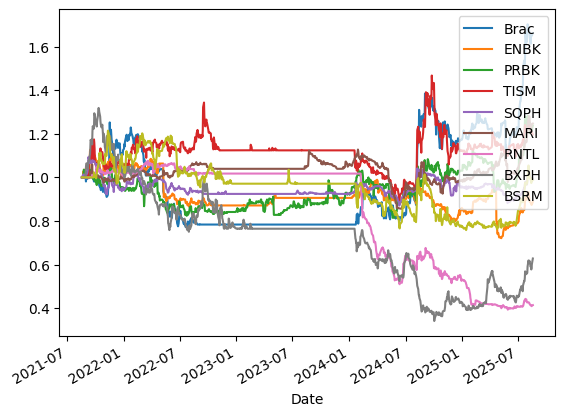

In [13]:
stock_normed = close/close.iloc[0]
save = stock_normed.plot()
fig =save.get_figure()
fig.savefig("relative_g.png",dpi=300)

In [14]:
#define negative sharp raio
def neg_sharp_ratio(weights,log_returns,cov_matrix,riskfree_rate):
    return -sharp_ratio(weights,log_returns,cov_matrix,riskfree_rate)
    

In [15]:
stocks =['Brac','ENBK','PRBK','TISM','SQPH','MARI','RNTL','BXPH','BSRM']
constraints = {'type':'eq','fun': lambda weights : np.sum(weights)-1.0}
bounds = [(0.5,0.4) for _ in range(len(stocks))]
bounds = [(0.05, 0.4) for _ in range(len(stocks))]

In [16]:
initial_weights = np.array([1/len(stocks)]* len(stocks))
print(initial_weights)

[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]


In [17]:
optimized_results = minimize(neg_sharp_ratio, initial_weights, args=(log_returns, cov_matrix, riskfree_rate), method = 'SLSQP', constraints=constraints, bounds=bounds)

In [18]:
print(optimized_results)

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 0.7385933945627063
           x: [ 4.000e-01  5.000e-02  5.000e-02  5.000e-02  5.000e-02
                5.000e-02  5.000e-02  2.500e-01  5.000e-02]
         nit: 4
         jac: [-1.182e+00 -2.699e-01 -4.143e-01 -4.590e-01 -1.938e-01
               -1.387e-01  6.665e-02 -8.444e-01 -3.524e-01]
        nfev: 40
        njev: 4
 multipliers: [-8.444e-01]


In [19]:
#get the optimal weights
optimal_weights = optimized_results.x
print(optimal_weights)

[0.4  0.05 0.05 0.05 0.05 0.05 0.05 0.25 0.05]


In [20]:
print('optimal weights')
for stock, weight in zip(stocks, optimal_weights):
    print(f"{stock}: {weight:.2f}")

print()

optimal_portfolio_return = np.sum(log_returns.mean() *optimal_weights *240)
optimal_portfolio_volatility = np.sqrt(optimal_weights.T @ cov_matrix @ optimal_weights)
optimal_sharp_ratio = sharp_ratio(optimal_weights,log_returns,cov_matrix,riskfree_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Expected Sharp Ratio: {optimal_sharp_ratio:.4f}")

optimal weights
Brac: 0.40
ENBK: 0.05
PRBK: 0.05
TISM: 0.05
SQPH: 0.05
MARI: 0.05
RNTL: 0.05
BXPH: 0.25
BSRM: 0.05

Expected Annual Return: 0.0167
Expected Volatility: 0.1324
Expected Sharp Ratio: -0.7386


In [21]:
n_assets = len(stocks)
n_portfolios = 15000

In [31]:
ret_array = np.zeros(n_portfolios)
vol_array = np.zeros(n_portfolios)
sharp_array = np.zeros(n_portfolios)
weights_record = []

In [52]:
for i in range(n_portfolios):
    weights = np.random.random(n_assets)
    weights /=np.sum(weights)
    weights_record.append(weights)

    port_return = np.sum(log_returns.mean() *weights *240)
    ret_array[i]= port_return

    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    vol_array[i] = port_vol

    sharp_array[i] = (port_return-riskfree_rate) / port_vol

In [64]:
max_sharp_idx = sharp_array.argmax()
msr_return = ret_array[max_sharp_idx]
msr_vol = vol_array[max_sharp_idx]
msr_weights = weights_record[max_sharp_idx]

print('Max Sharp Ratio Portfolio: ')
print(f"Return: {msr_return:.2f}")
print(f"Volatility:  {msr_vol:.2f}")

weights_df= pd.DataFrame({
    "Stock": stocks,
    "Optimal Weights": msr_weights
})
print(weights_df)

Max Sharp Ratio Portfolio: 
Return: 0.06
Volatility:  0.13
  Stock  Optimal Weights
0  Brac         0.141132
1  ENBK         0.148650
2  PRBK         0.016321
3  TISM         0.079876
4  SQPH         0.117243
5  MARI         0.080945
6  RNTL         0.164353
7  BXPH         0.110365
8  BSRM         0.141115


In [67]:
min_vol_idx = vol_array.argmin()
GMV_ret = ret_array[min_vol_idx]
GMV_vol = vol_array[min_vol_idx]
GMV_weights = weights_record[min_vol_idx]

print(f"Global Minimum Variance Portfolio: ")
print(f"Minimum Return: {GMV_ret:.2f}")
print(f"Minimum Risk: {GMV_vol:.2f}")

Min_weights_df = pd.DataFrame({
    "Stock": stocks,
    "Min Weights": GMV_weights
})

print(Min_weights_df)

Global Minimum Variance Portfolio: 
Minimum Return: -0.03
Minimum Risk: 0.07
  Stock  Min Weights
0  Brac     0.011947
1  ENBK     0.048024
2  PRBK     0.152376
3  TISM     0.201468
4  SQPH     0.023237
5  MARI     0.256600
6  RNTL     0.098272
7  BXPH     0.186651
8  BSRM     0.021425


In [70]:
import matplotlib.pyplot as plt

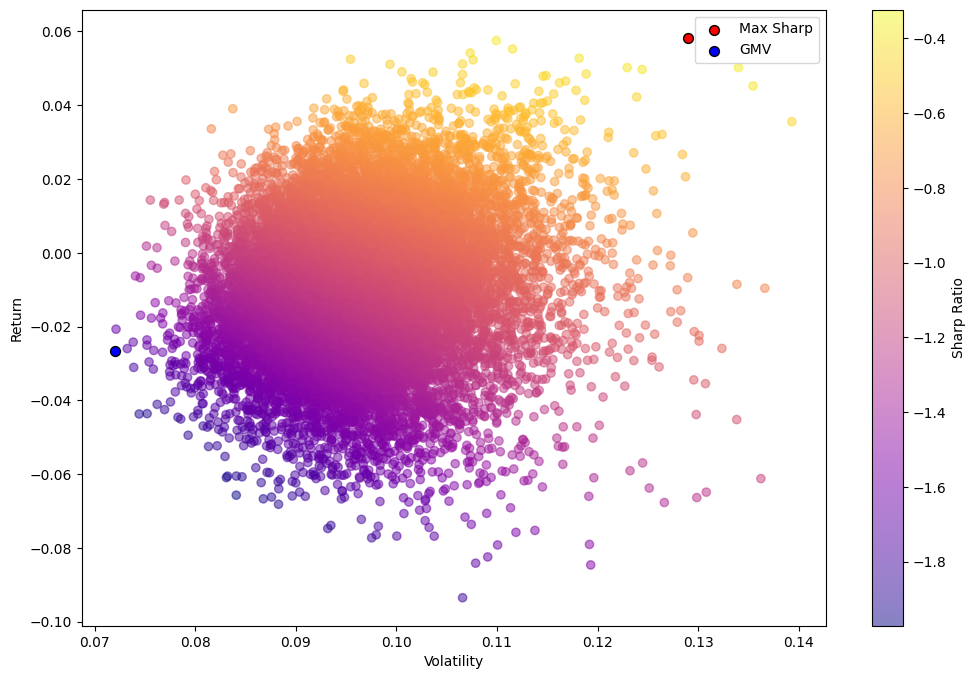

In [88]:

plt.figure(figsize=(12,8))
plt.scatter(vol_array, ret_array, c=sharp_array, cmap = "plasma", alpha =.5 )
plt.colorbar(label="Sharp Ratio")
plt.xlabel("Volatility")
plt.ylabel("Return")

# Highlight Max Sharpe Ratio (red) and GMV (green)
plt.scatter(msr_vol, msr_return ,c="red", s=50, edgecolors ="black", label ="Max Sharp")
plt.scatter(GMV_vol, GMV_ret, c="blue", s=50, edgecolors ="black", label ="GMV")
plt.legend()
plt.show()